In [1]:
#Load packacges
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing, decomposition
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, precision_score, f1_score
from sklearn.model_selection import cross_val_score
from mlxtend.plotting import plot_decision_regions

import warnings
warnings.filterwarnings("ignore")

### 1. Data analisys and visualization

In [2]:
#Load train and test data
data_train = np.load('MLProject2024/fashion_train.npy')
data_test = np.load('MLProject2024/fashion_test.npy')
class_mapping = {0:'Top',1:'Trouser',2:'Pullover',3:'Dress',4:'Shirt'}

print("Shape of the data:", data_train.shape)

train_images = data_train[:, :-1] 
train_labels = data_train[:, -1]  

test_images = data_test[:, :-1]
test_labels = data_test[:, -1]


print("Shape of images:", train_images.shape)
data_train[:10]

Shape of the data: (10000, 785)
Shape of images: (10000, 784)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 2],
       [0, 0, 0, ..., 0, 0, 2],
       [0, 0, 0, ..., 0, 0, 1]], dtype=uint8)

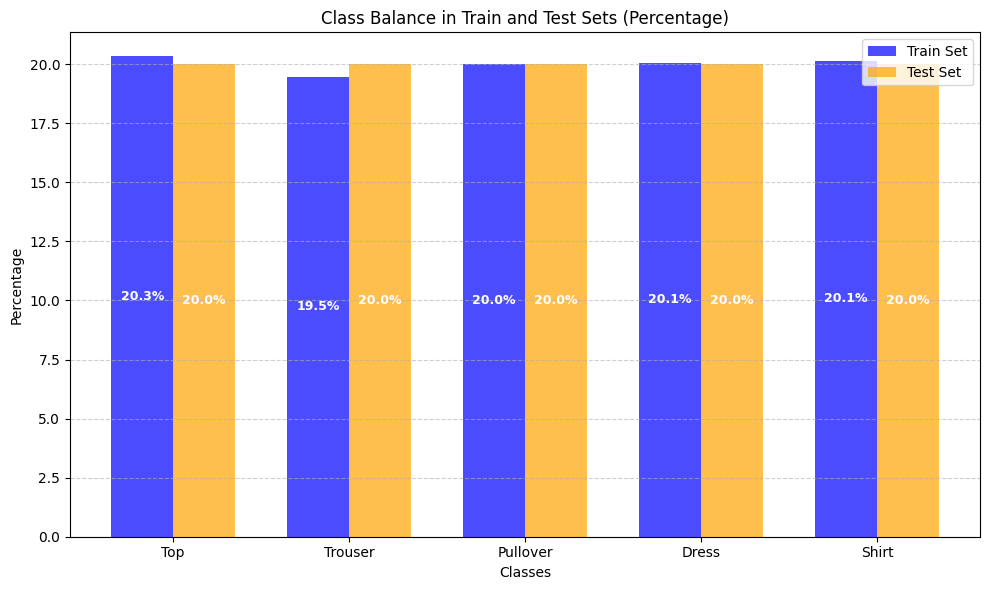

In [3]:
# Count label occurrences
train_counts = np.bincount(train_labels, minlength=5)
test_counts = np.bincount(test_labels, minlength=5)

# Normalize counts to percentages
train_percent = train_counts / train_counts.sum() * 100
test_percent = test_counts / test_counts.sum() * 100

# Prepare class labels
class_labels = [class_mapping[i] for i in range(5)]

# Plot
labels = np.arange(5)
width = 0.35  # Bar width

fig, ax = plt.subplots(figsize=(10, 6))

# Bars for train and test
train_bars = ax.bar(labels - width/2, train_percent, width, label='Train Set', color='blue', alpha=0.7)
test_bars = ax.bar(labels + width/2, test_percent, width, label='Test Set', color='orange', alpha=0.7)

# Add percentages in the middle of bars
for bar, percent in zip(train_bars, train_percent):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height()/2, f"{percent:.1f}%", 
            ha='center', va='center', fontsize=9, color='white', weight='bold')

for bar, percent in zip(test_bars, test_percent):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height()/2, f"{percent:.1f}%", 
            ha='center', va='center', fontsize=9, color='white', weight='bold')

# Add labels and legend
ax.set_xlabel('Classes')
ax.set_ylabel('Percentage')
ax.set_title('Class Balance in Train and Test Sets (Percentage)')
ax.set_xticks(labels)
ax.set_xticklabels(class_labels)
ax.legend()

# Add gridlines for better comparison
ax.yaxis.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


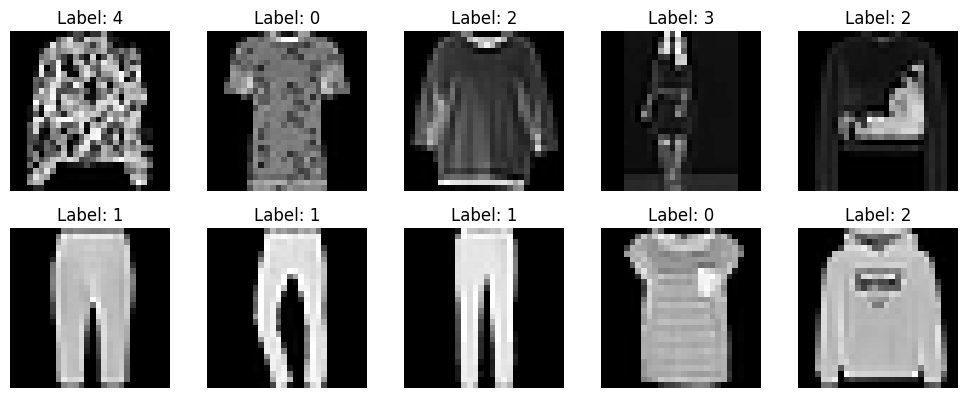

In [22]:
def plot_sample_images(images, labels, num_samples=10):
    random_indices = np.random.choice(images.shape[0], num_samples, replace=False) 

    plt.figure(figsize=(10, 10))
    for i in range(num_samples):
        plt.subplot(5, 5, i + 1)  
        plt.imshow(images[random_indices[i]].reshape(28, 28), cmap='gray')  
        plt.title(f'Label: {labels[random_indices[i]]}') 
        plt.axis('off')
    plt.tight_layout()
    plt.show()


plot_sample_images(train_images, train_labels)

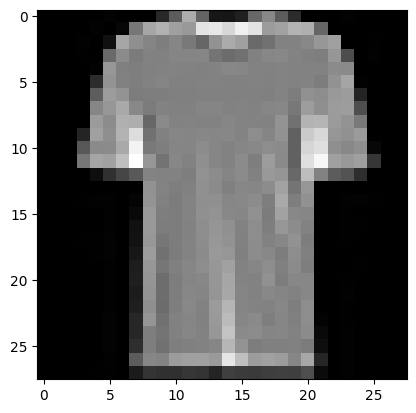

In [23]:
curr_img = np.reshape(data_train[0][:-1], (28,28))
plt.imshow(curr_img, cmap=plt.cm.gray)

In [24]:
train_df = pd.DataFrame(data_train)
train_df.iloc[:,-1].replace(class_mapping, inplace=True)

In [25]:
test_df = pd.DataFrame(data_test)
test_df.iloc[:,-1].replace(class_mapping, inplace=True)

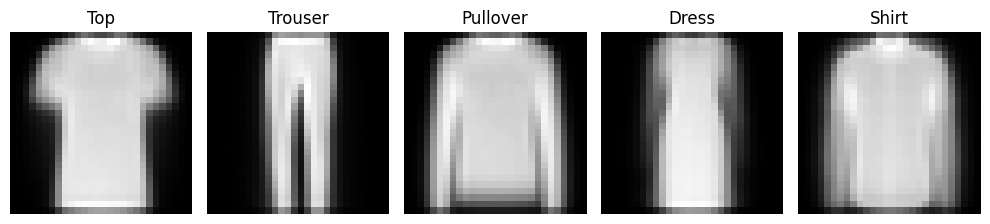

In [26]:
mean_images = []
for label in range(5):
    mean_image = np.mean(train_images[train_labels == label], axis=0).reshape(28, 28)
    mean_images.append(mean_image)

plt.figure(figsize=(10, 8))
for i, mean_image in enumerate(mean_images):
    plt.subplot(1, 5, i + 1)
    plt.imshow(mean_image, cmap='gray')
    plt.title(class_mapping[i])
    plt.axis('off') 
plt.tight_layout()
plt.show()

In [27]:
mean = np.mean(data_train)
median = np.median(data_train)
minn = np.min(data_train)
maxx = np.max(data_train)
std = np.std(data_train)
print(f"{mean}, {median}, {minn}, {maxx}, {std}")

76.93116420382165, 14.0, 0, 255, 89.97942562765583


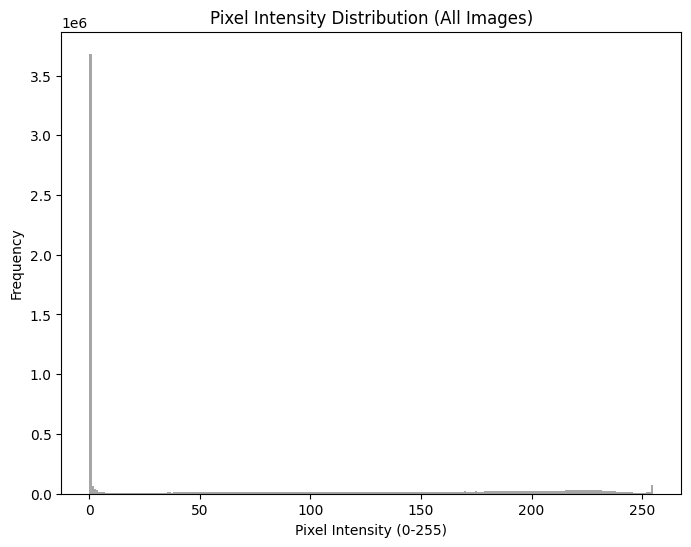

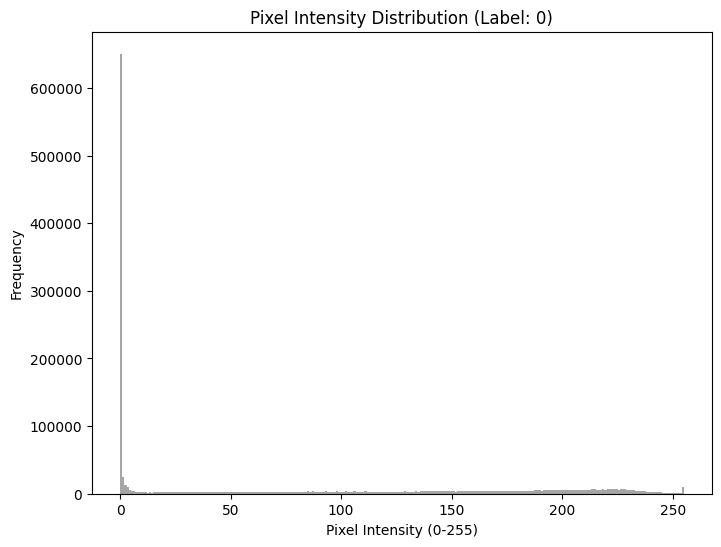

In [28]:
def plot_intensity_histogram(images, labels=None, label=None, bins=256):
    if label is not None:
        images = images[labels == label]
    
    all_pixels = images.flatten()

    plt.figure(figsize=(8, 6))
    plt.hist(all_pixels, bins=bins, color='gray', alpha=0.7)
    plt.title(f'Pixel Intensity Distribution (Label: {label})' if label is not None else 'Pixel Intensity Distribution (All Images)')
    plt.xlabel('Pixel Intensity (0-255)')
    plt.ylabel('Frequency')
    plt.show()

plot_intensity_histogram(train_images)

plot_intensity_histogram(train_images, labels=train_labels, label=0)

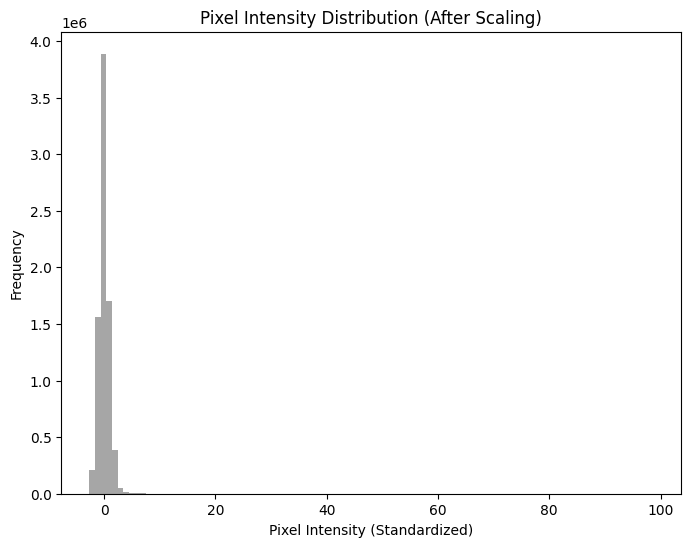

In [29]:
x = train_df.loc[:, :783].values
x = preprocessing.StandardScaler().fit_transform(x)
x.shape

x_test = test_df.loc[:, :783].values
x_test = preprocessing.StandardScaler().fit_transform(x_test)

flattened_scaled_pixels = x.flatten()

plt.figure(figsize=(8, 6))
plt.hist(flattened_scaled_pixels, bins=100, color='gray', alpha=0.7)
plt.title('Pixel Intensity Distribution (After Scaling)')
plt.xlabel('Pixel Intensity (Standardized)')
plt.ylabel('Frequency')
plt.show()

### 2. PCA for all features and visualization

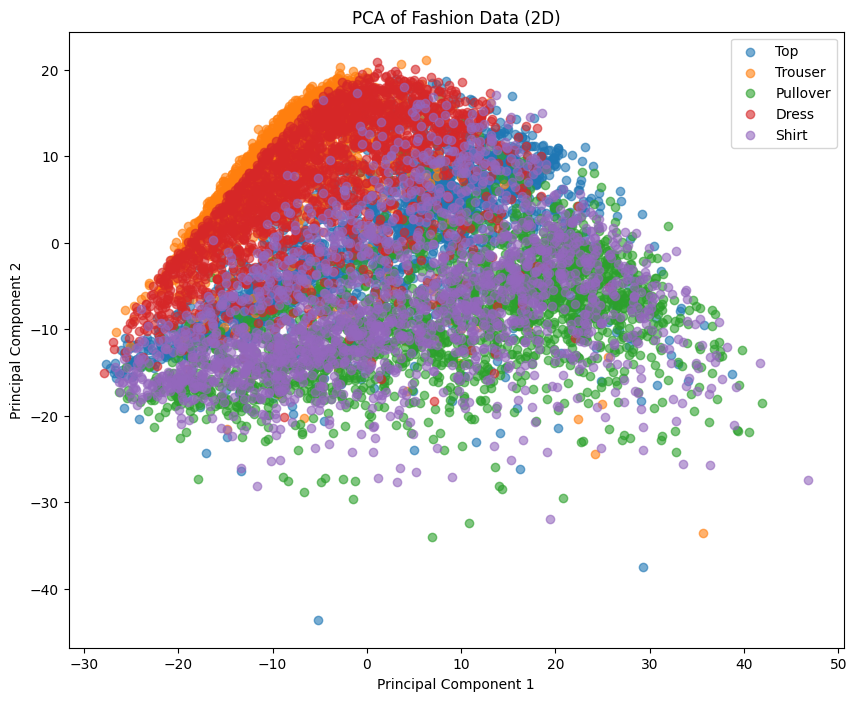

In [30]:
#PCA for all features
pca_all = decomposition.PCA()
pca_train_all = pca_all.fit_transform(x)
pca_test_all = pca_all.transform(x_test)

plt.figure(figsize=(10, 8))

for label in np.unique(train_labels):
    plt.scatter(pca_train_all[train_labels == label, 0], pca_train_all[train_labels == label, 1], 
                label=class_mapping[label], alpha=0.6)

plt.title('PCA of Fashion Data (2D)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

In [31]:
print(pca_all.components_[:10])

[[ 5.82637305e-04  2.30631247e-03  2.34926124e-03 ...  1.33195002e-02
   5.81313508e-03  1.05615622e-03]
 [-9.84719199e-05 -2.29457213e-03 -5.69148192e-03 ... -2.04898046e-02
  -1.15426244e-02 -5.48839695e-03]
 [ 2.67124552e-03  1.05684466e-02  2.12765921e-02 ...  1.50343917e-03
   8.26990505e-03  6.90042583e-03]
 ...
 [-1.16550288e-02 -1.50928886e-02 -7.27539697e-02 ... -4.06647203e-02
  -4.09376326e-02 -3.89489033e-02]
 [ 9.23812166e-03  1.55193410e-03  3.31504832e-02 ...  7.72038486e-03
  -1.42891657e-02 -6.12657394e-03]
 [ 3.23172510e-02  2.92877030e-02  8.44633990e-02 ... -2.67592412e-02
  -1.26700156e-03  3.89846291e-02]]


In [32]:
print(sum(pca_all.explained_variance_ratio_[:110]))
print(pca_all.explained_variance_ratio_[:110])

0.899085633605069
[0.22645698 0.13673557 0.06381166 0.05046707 0.03064291 0.02924805
 0.02197067 0.01880203 0.0147053  0.01416444 0.01298674 0.01232636
 0.01005118 0.00914286 0.00886118 0.00844979 0.00800824 0.0074046
 0.0071842  0.00678097 0.00637763 0.00625898 0.0059261  0.00557587
 0.00524909 0.00501018 0.00489192 0.0047749  0.00451686 0.00424941
 0.00419099 0.00403955 0.00393599 0.00388444 0.00379559 0.00362945
 0.00357774 0.00351894 0.00333661 0.00324689 0.00315796 0.00312242
 0.00298242 0.00291243 0.00277144 0.00273708 0.0026438  0.00258013
 0.00245687 0.00243532 0.002335   0.00228124 0.0022166  0.00216888
 0.00211117 0.00205265 0.0020176  0.00196418 0.0019223  0.00186012
 0.00181671 0.00179017 0.00176835 0.00172591 0.00167618 0.00165702
 0.00162515 0.00159048 0.00158136 0.00152019 0.00149526 0.00147891
 0.00146017 0.00144748 0.00142196 0.00141197 0.00139531 0.00136788
 0.00134884 0.00131928 0.00129775 0.00127872 0.00125089 0.00124339
 0.00121723 0.00119065 0.00115931 0.0011546  

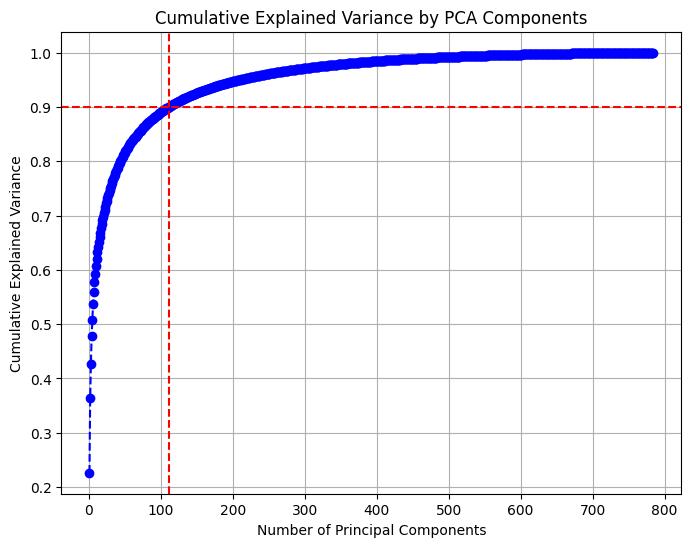

In [33]:
explained_variance_ratio = pca_all.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--', color='b')

plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.axhline(y=0.90, color='r', linestyle='--')  
plt.axvline(x=np.argmax(cumulative_explained_variance >= 0.90) + 1, color='r', linestyle='--') 

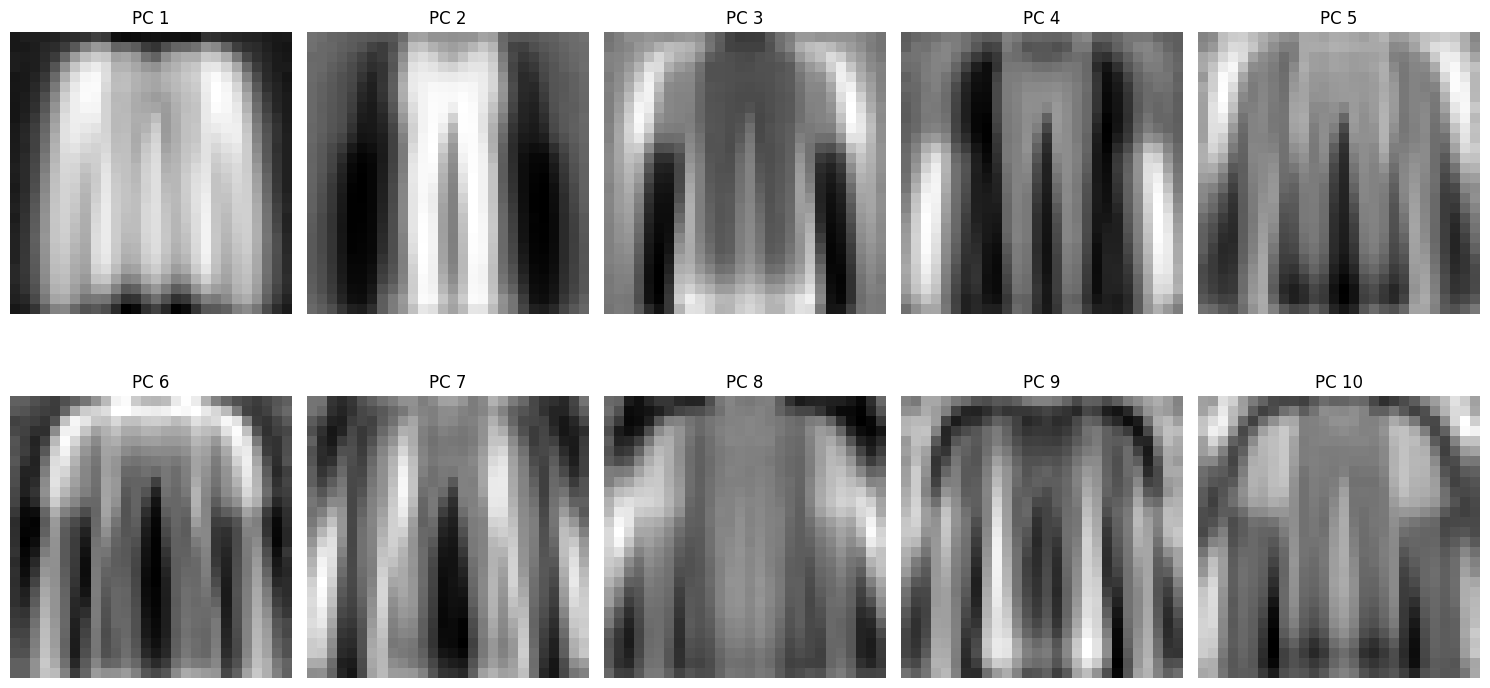

In [34]:
plt.figure(figsize=(15, 8))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(pca_all.components_[i].reshape(28, 28), cmap='gray')
    plt.title(f'PC {i + 1}')
    plt.axis('off')
plt.tight_layout()
plt.show()


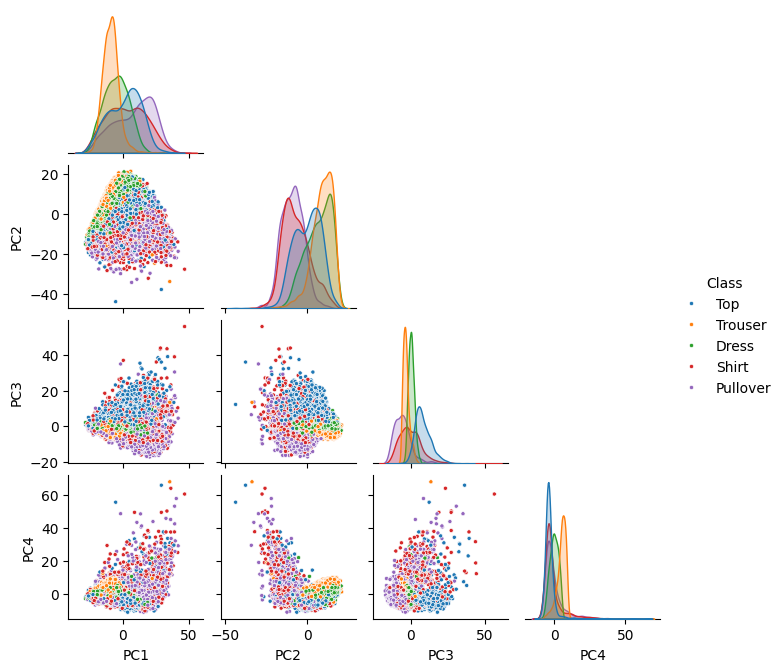

In [35]:
pc_labels = ['PC' + str(a) for a in range(1, len(pca_train_all[0])+1)]
pca_df = pd.DataFrame(pca_train_all, columns = pc_labels)

y = train_df.iloc[:,-1]

pca_4 = pca_df.copy()
pca_4 = pca_4[['PC1','PC2','PC3','PC4']]
pca_4['Class'] = y.reset_index(drop=True) 

sns.pairplot(data=pca_4,hue='Class',corner=True, markers = '.',height=1.7)
plt.show()

### For further calcualtion, we are deifining the PCAs with all, 2 and 110 features for our test and train data

In [36]:
# pca with all features for test
# pca_train_all and  pca_test_all are already defined

# pca with 2 features for train and test
pca_2 = decomposition.PCA(2)
pca_train_2 = pca_2.fit_transform(x)
pca_test_2 = pca_2.transform(x_test)

# pca with 110 features for train and test
pca_110 = decomposition.PCA(110)
pca_train_110 = pca_110.fit_transform(x)
pca_test_110 = pca_110.transform(x_test)

#pca with 10 freatures for train and test
pca_10 = decomposition.PCA(10)
pca_train_10 = pca_10.fit_transform(x)
pca_test_10 = pca_10.transform(x)


### 3. knn implementation 

###### 3.1. Data definition


Use the next code chunk for calcuating the metrics with **raw data**

In [37]:
# X_train, y_train = data_train[:, : -1], data_train[:, -1]
# X_test, y_train = data_train[:, : -1], data_train[:, -1]
# num_of_features = 'raw data with no'

Use the next code chunk for calcuating the metrics with **full pca** data

In [38]:
# # #defining the X an y training and testing data (with PCA)
# # - why do we have worse results pca_data 
X_train, y_train = pca_train_all, train_labels
X_test, y_test = pca_test_all, test_labels
num_of_features = 'all'

Use this code chunk for calcuating the metrics with **pca data with 2** features

In [39]:
# # #defining the X an y training and testing data (with PCA)
# # - why do we have worse results pca_data ??
# X_train, y_train = pca_train_2, train_labels
# X_test, y_test = pca_test_2, test_labels
# num_of_features = '2'

Use this code chunk for calcuating the metrics with **pca data with 110** features

In [40]:
# #defining the X an y training and testing data (with PCA)
# - why do we have worse results pca_data ??
X_train, y_train = pca_train_110, train_labels
X_test, y_test = pca_test_110, test_labels
num_of_features = '110'

###### 3.2 Calculating the metrics for knn

In [41]:
# fitting more neighbours: 
k_values = [i for i in range(1,31)]
knn_fit = []

for k in k_values:
    knn_fit.append(KNeighborsClassifier(k).fit(X_train, y_train))

In [42]:
# make predictions and measure accuracy for each model:
y_pred = []
for knn_classifier in knn_fit:
    y_pred.append(knn_classifier.predict(X_test))

# calcualte accuracy
accuracy_values = []
for pred in y_pred: 
    accuracy_values.append(accuracy_score(y_test, pred))

#add recall for further evaluation
recall_values = []
for pred in y_pred:
    recall_values.append(recall_score(y_test, pred, average='macro')) #macro gives equal weight to each class

#add precision
precision_values = []
for i in range(len(y_pred)):
    precision_values.append(precision_score(y_test, y_pred[i], average='macro'))

# F1 score
f1_scores = []
for i in range(len(y_pred)):
    f1_scores.append(f1_score(y_test, y_pred[i], average='macro'))



In [43]:
#creating a table with all the scores calcualted before

print("{:<10} | {:^10} | {:^10} | {:^10} | {:^10}".format("Neighbors", "Accuracy", "Recall", "Precision", "F1"))
print("-" * 60)
for i in range(len(k_values)):
    print("{:<10} | {:^10.5f} | {:^10.5f} | {:^10.5f} | {:^10.5f}".format(
        k_values[i], accuracy_values[i], recall_values[i], precision_values[i], f1_scores[i]
    ))

Neighbors  |  Accuracy  |   Recall   | Precision  |     F1    
------------------------------------------------------------
1          |  0.81380   |  0.81380   |  0.81569   |  0.81465  
2          |  0.80920   |  0.80920   |  0.81524   |  0.80231  
3          |  0.81840   |  0.81840   |  0.82031   |  0.81848  
4          |  0.82420   |  0.82420   |  0.82468   |  0.82110  
5          |  0.82840   |  0.82840   |  0.82838   |  0.82739  
6          |  0.82900   |  0.82900   |  0.82822   |  0.82663  
7          |  0.82620   |  0.82620   |  0.82589   |  0.82527  
8          |  0.82880   |  0.82880   |  0.82783   |  0.82673  
9          |  0.82700   |  0.82700   |  0.82661   |  0.82575  
10         |  0.83060   |  0.83060   |  0.82991   |  0.82881  
11         |  0.83040   |  0.83040   |  0.83009   |  0.82936  
12         |  0.83020   |  0.83020   |  0.82953   |  0.82854  
13         |  0.82900   |  0.82900   |  0.82857   |  0.82787  
14         |  0.83040   |  0.83040   |  0.82981   |  0.82

In [44]:
#calcuating the highest precision neighbour
max_index = precision_values.index(max(precision_values))
max_index

20

###### 3.3. Plotting and evaluation

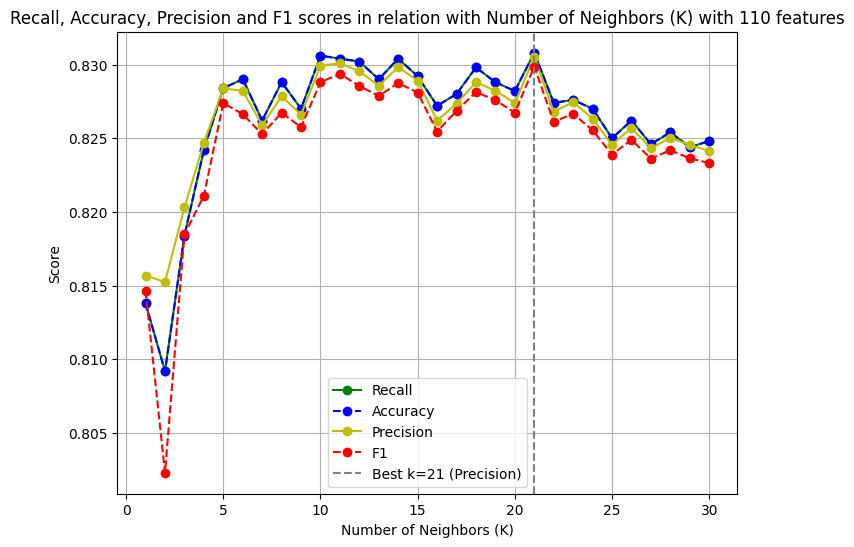

In [45]:
# Plotting Recall and Accuracy on the same plot
plt.figure(figsize=(8, 6))

plt.plot(k_values, recall_values, marker='o', linestyle='-', color='g', label='Recall')
plt.plot(k_values, accuracy_values, marker='o', linestyle='--', color='b', label='Accuracy')
plt.plot(k_values, precision_values, marker='o', linestyle='-', color='y', label='Precision')
plt.plot(k_values, f1_scores, marker='o', linestyle='--', color='r', label='F1')
plt.axvline(k_values[max_index], color='gray', linestyle='--', label=f'Best k={k_values[max_index]} (Precision)')

plt.title(f'Recall, Accuracy, Precision and F1 scores in relation with Number of Neighbors (K) with {num_of_features} features')
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Score')
plt.grid(True)
plt.legend(loc='best')
plt.show()

As accuracy and recall and are basically almost the same, it can mean these things:
1. Balanced Classes
2. High model performance
3. Few false negatives

In [46]:
print(f"The plot show that the best measure what we can use is precision, with {k_values[max_index]} neighbours. ")

The plot show that the best measure what we can use is precision, with 21 neighbours. 


###### 3.4. Cross-validation

In [47]:
# cross validation with k = 7 fold
cv_values = []
cv_means = []

for knn_classifies in knn_fit:
    cv_values.append(cross_val_score(knn_classifies, x, train_labels, cv=7, scoring='precision_macro'))
for i in range(len(k_values)):
    cv_means.append(cv_values[i].mean())

In [48]:
print(f"For {k_values[max_index]} neighbors the cross validation scores for precision are {cv_values[max_index]}")
print(f"With their mean {cv_means[max_index]}")
print(60*'-')

For 21 neighbors the cross validation scores for precision are [0.83497437 0.8308404  0.82616317 0.82080006 0.84247363 0.7989033
 0.84156812]
With their mean 0.8279604341620759
------------------------------------------------------------


In [49]:
final_model = KNeighborsClassifier(n_neighbors=max_index).fit(x, train_labels)
y_test_pred = final_model.predict(x_test)
test_precision = precision_score(test_labels, y_test_pred, average='macro')

print(f"Best number of neighbors (k) based on CV precision: {max_index+1}")
print(f"Test set precision with best k: {test_precision}")

Best number of neighbors (k) based on CV precision: 21
Test set precision with best k: 0.8197825558766431


###### 3.5. Confusion matrix and decision boundaries

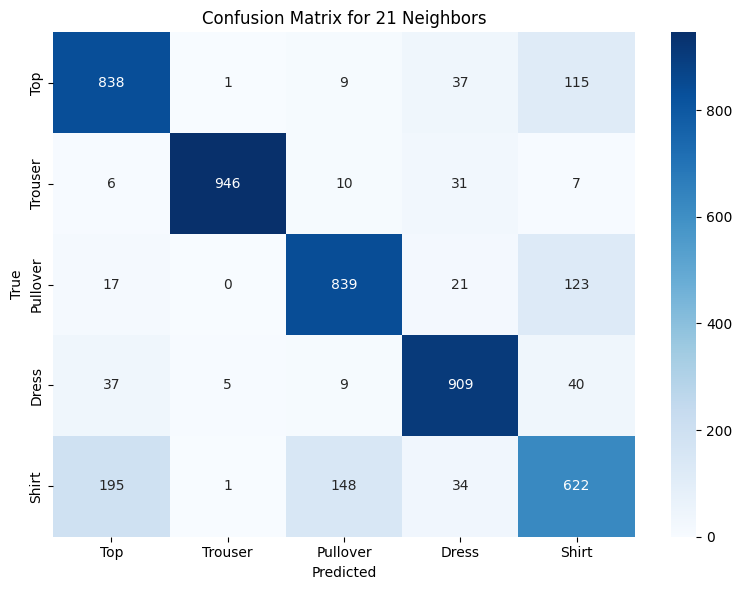

In [50]:
# Confusion matrix for best k
def plot_confusion_matrix(y_test, y_pred, title):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(class_mapping.values()), yticklabels=list(class_mapping.values()))
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(test_labels, y_pred[max_index], f'Confusion Matrix for {k_values[max_index]} Neighbors')


In [51]:
# Plot decision boundaries - planned! 


### 4. Decision tree implementation

#### 4.1. Defining base functions for DT

In [52]:
#functions for decision tree
# -gini group 
# -gini split
# -split
# -best split
# -decision tree
#

# gini = 1- sum(p)
#p=p0**2+p1**2+p2**2+p3**2+p4**2+p5**2 
#p0 = n0/n
#p1 = n1/n
#p2 = n2/n
#p3 = n3/n
#p4 = n4/n
#p5 = n5/n
#n0 = number of samples in class 0
#n1 = number of samples in class 1
#n2 = number of samples in class 2
#n3 = number of samples in class 3
#n4 = number of samples in class 4
#n = total number of samples in the group

def gini_group(dataset):
    '''takes one group of data and calculates the gini impurity of that'''
    
    counts=np.bincount(labels) #count the number of samples in each class
    n0, n1, n2, n3, n4 = counts 
    n = n0+n1+n2+n3+n4 
    if n == 0: #if the group is empty, gini impurity is 0
        return 0
    p0 = n0/n
    p1 = n1/n
    p2 = n2/n
    p3 = n3/n
    p4 = n4/n
    
    p = p0**2+p1**2+p2**2+p3**2+p4**2
    gini = 1- p
    return gini

def gini_split(left, right):
    '''takes two groups of data and calculates the gini impurity of the split'''
    n_left=len(left)
    n_right=len(right)
    n_total=n_left+n_right
    if n_total == 0: 
        return 0
    gini_split=n_left/n_total*gini_group(left)+n_right/n_total*gini_group(right)
    return gini_split
    
def split (dataset, column, value):
    '''takes a dataset, a column and a value and splits the dataset 
    into two groups based on the value(threshold) of the column, 
    returns two groups'''
    left = []
    right = []
    for row in dataset:
        if row[column] < value:
            left.append(row)
        else:
            right.append(row)
    return np.array(left), np.array(right)
    

def best_split(data):
    '''Finds the best split for the dataset and returns the split details.'''
    best_gini = 1
    best_column = None
    best_value = None
    best_left = None
    best_right = None

    for column in range(data.shape[1] - 1):  # Exclude label column
        unique_values = np.unique(data[:, column])  # Unique values for potential split points
        for value in unique_values:
            left, right = split(data, column, value)
            gini = gini_split(left, right)
            if gini < best_gini:
                best_gini = gini
                best_column = column
                best_value = value
                best_left = left
                best_right = right

def build_tree (min_samples, data): #limit the minimum number of samples in a group, !consider adding max depth or other limits
    if len(data) < min_samples:
        return data
    current_data=data
    best_left, best_right, best_column, best_value = best_split(current_data)
    
    #TBD 

In [53]:
def accuracy(y_test,y_pred):
    return np.sum((y_test == y_pred)/ len(y_test))


In [54]:
from DecisionTreeGini import DecisionTreeGini

clf_1 = DecisionTreeGini(max_depth=5)
clf_1.fit(pca_train_2, train_labels)
y_pred_pca_2 = clf_1.predict(pca_test_2)

accuracy(test_labels, y_pred_pca_2)

np.float64(0.5664)

In [55]:
from sklearn import tree

clf_3 = tree.DecisionTreeClassifier(max_depth=5)
clf_3 = clf_3.fit(pca_train_2, train_labels)
prediction_3 = clf_3.predict(pca_test_2)

accuracy(test_labels, prediction_3)


np.float64(0.5666)